<a href="https://colab.research.google.com/github/grupos4g4/PROJAPLIC2/blob/main/Projeto_Aplicado_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import re
import cv2
import shutil
import random
from PIL import Image
import numpy as np
import torch.nn as nn
import seaborn as sns
import pandas as pd
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from torchvision.models import ResNet50_Weights
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
dir_principal = "C:/Users/samue/OneDrive/Documentos/PROJETO_APLICADO"
dataset = os.path.join(dir_principal, "Fruit Data _Base")

In [ ]:
for root, dirs, files in os.walk(dir_principal):
    print(f'Diretório: {root}')  # Exibe o diretório atual
    for filename in files:
        print(f'  Encontrado arquivo: {filename}')  # Exibe cada arquivo encontrado

### Quantidade de imagens para trabalho

In [ ]:
# Dicionário para armazenar a contagem de imagens por fruta
fruit_counts = defaultdict(int)

# Contador para total geral de imagens
total_images = 0

image_extensions = ('.png', '.jpg', '.jpeg')

# Função para normalizar o nome da fruta
def normalize_fruit_name(name):
    # Extrai a parte principal do nome da fruta
    match = re.match(r'^(apple).*', name, re.IGNORECASE)
    return match.group(1).lower() if match else name.lower()

# Percorrendo todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset):
    for filename in files:
        if filename.lower().endswith(image_extensions):  # Verifica se o arquivo é uma imagem PNG
            # Normaliza o nome da fruta a partir da subpasta
            fruit_name = normalize_fruit_name(os.path.basename(root))
            # Incrementa a contagem para a fruta correspondente
            fruit_counts[fruit_name] += 1
            # Incrementa o contador total de imagens
            total_images += 1
# Exibindo os resultados
print("Total de imagens por tipo de fruta:")
for fruit, count in fruit_counts.items():
    print(f'Total de imagens para {fruit}: {count}')
# Exibindo o total geral de imagens
print(f"\nTotal geral de imagens: {total_images}")


Total de imagens por tipo de fruta:
Total de imagens para apple: 5024
Total de imagens para banana: 3027
Total de imagens para carambola: 2080
Total de imagens para guava: 4008
Total de imagens para kiwi: 4173
Total de imagens para mango: 4154
Total de imagens para muskmelon: 2078
Total de imagens para orange: 3012
Total de imagens para peach: 2629
Total de imagens para pear: 3012
Total de imagens para persimmon: 2072
Total de imagens para pitaya: 2501
Total de imagens para plum: 2298
Total de imagens para pomegranate: 2167
Total de imagens para tomatoes: 2171

Total geral de imagens: 44406


### Analise de Distribuição

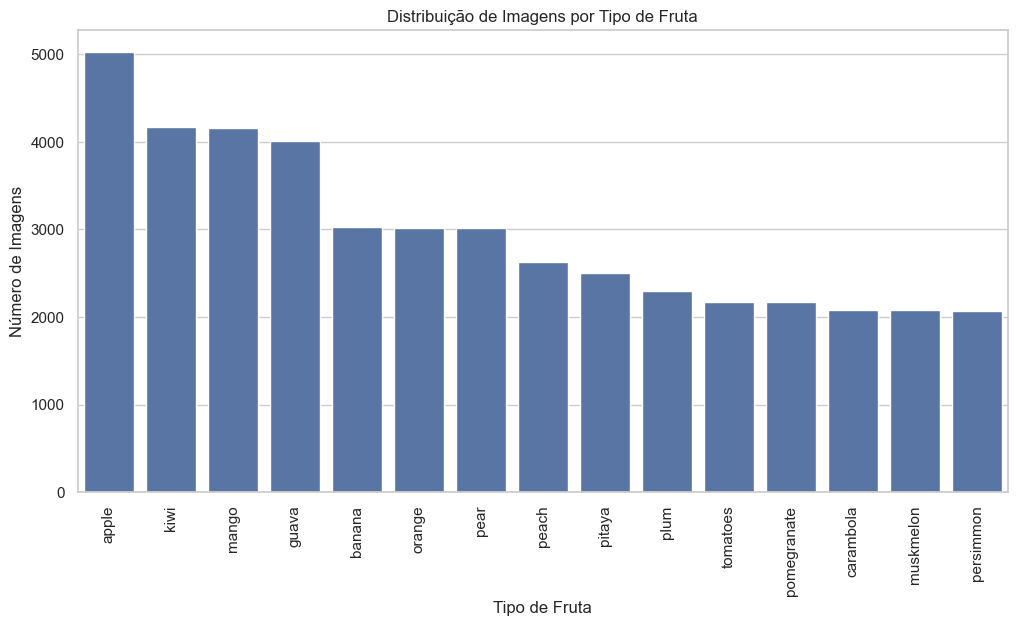

In [ ]:
fruit_df = pd.DataFrame(list(fruit_counts.items()), columns=['Fruit', 'Count'])
# Configurando o estilo do gráfico
sns.set(style="whitegrid")

# Criando um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Fruit', y='Count', data=fruit_df.sort_values('Count', ascending=False))
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.title('Distribuição de Imagens por Tipo de Fruta')
plt.xlabel('Tipo de Fruta')
plt.ylabel('Número de Imagens')
plt.show()


In [ ]:
# Criando um DataFrame a partir do dicionário de contagens de frutas
fruit_df = pd.DataFrame(fruit_counts.items(), columns=['Fruit', 'Count'])

# Exibindo as primeiras linhas do DataFrame
print(fruit_df.head())

# Exibindo informações gerais do DataFrame
print(fruit_df.info())

# Exibindo estatísticas descritivas
print(fruit_df.describe())


       Fruit  Count
0      apple   5024
1     banana   3027
2  carambola   2080
3      guava   4008
4       kiwi   4173
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Fruit   15 non-null     object
 1   Count   15 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 372.0+ bytes
None
             Count
count    15.000000
mean   2960.400000
std     949.286333
min    2072.000000
25%    2169.000000
50%    2629.000000
75%    3517.500000
max    5024.000000


### Plotagem dos Dados

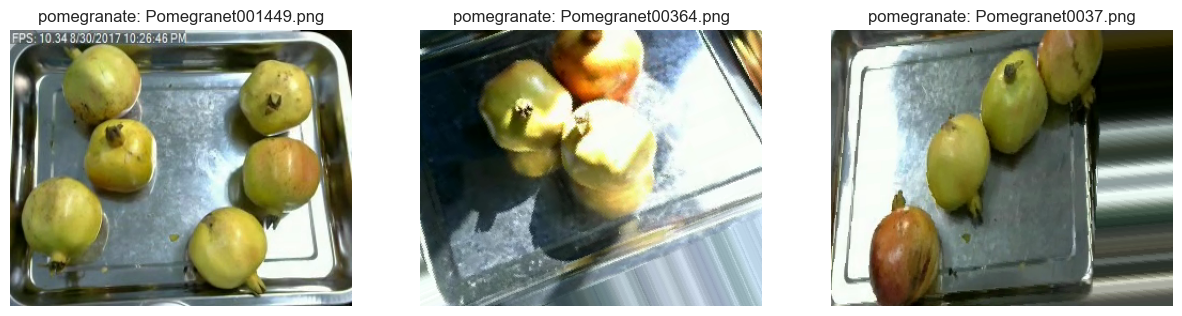

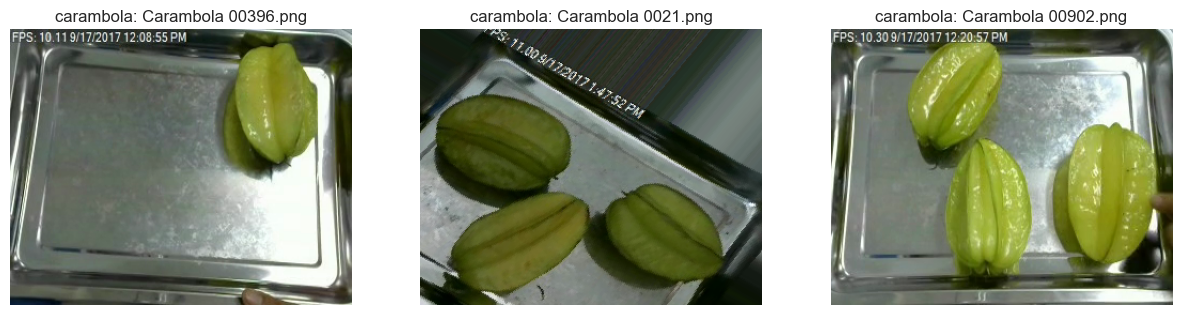

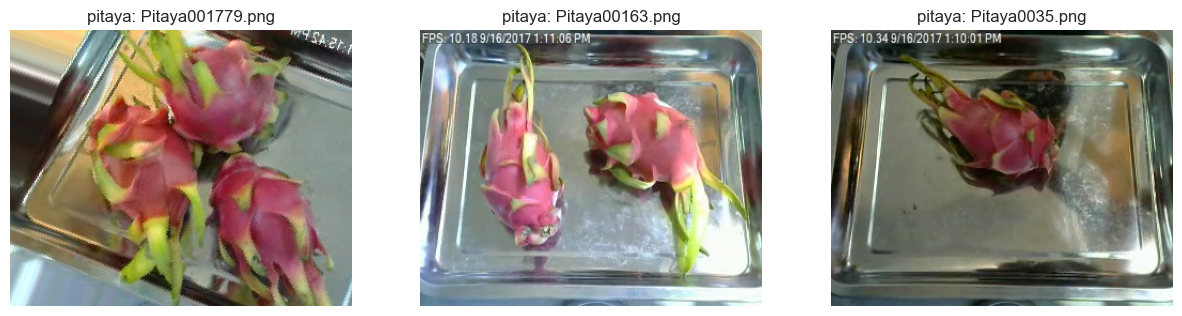

In [ ]:
# Função para mostrar imagens aleatórias
def show_random_images(fruit_name, dataset, num_images=3):
    # Caminho da pasta da fruta
    fruit_path = os.path.join(dataset, fruit_name)
    images = [img for img in os.listdir(fruit_path) if img.lower().endswith(image_extensions)]

    # Seleciona aleatoriamente as imagens
    selected_images = random.sample(images, min(num_images, len(images)))

    # Plotando as imagens
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(fruit_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{fruit_name}: {img_name}')
    plt.show()

# Mostrando amostras para algumas frutas
for fruit in fruit_df['Fruit'].sample(n=3).values:  # Seleciona aleatoriamente 3 frutas
    show_random_images(fruit, dataset)

### Separação dos Dados

In [ ]:
def listar_subdiretorios(dir):
    return [os.path.join(dir, nome)
        for nome in os.listdir(dir)
            if os.path.isdir(os.path.join(dir, nome))]

data_dir = listar_subdiretorios(dir_principal)

In [ ]:
base_dest_dir = "C:/Users/samue/OneDrive/Documentos/PROJETO_APLICADO/new_dataset_frutas"
train_dir, val_dir, test_dir = [os.path.join(base_dest_dir, x) for x in ['train', 'val', 'test']]
# Função para contar imagens em um diretório
def contar_imagens(dir):
    return sum([len(files) for _, _, files in os.walk(dir)])

# Contar e exibir as imagens em cada conjunto
for dir_name, dir_path in zip(["treino", "validação", "teste"], [train_dir, val_dir, test_dir]):
    print(f"Número total de imagens no conjunto de {dir_name}: {contar_imagens(dir_path)}")

Número total de imagens no conjunto de treino: 31076
Número total de imagens no conjunto de validação: 6662
Número total de imagens no conjunto de teste: 6668


In [ ]:
# Contar as imagens em cada conjunto
num_train = contar_imagens(train_dir)
num_val = contar_imagens(val_dir)
num_test = contar_imagens(test_dir)

# Número total de imagens
total_imagens = num_train + num_val + num_test

# Calcular porcentagens
porc_train = (num_train / total_imagens) * 100
porc_val = (num_val / total_imagens) * 100
porc_test = (num_test / total_imagens) * 100

# Exibir os resultados
print(f"Número total de imagens: {total_imagens}")
print(f"Treino: {num_train} imagens ({porc_train:.2f}%)")
print(f"Validação: {num_val} imagens ({porc_val:.2f}%)")
print(f"Teste: {num_test} imagens ({porc_test:.2f}%)")

Número total de imagens: 44406
Treino: 31076 imagens (69.98%)
Validação: 6662 imagens (15.00%)
Teste: 6668 imagens (15.02%)


### Transformação dos dados de train e val

In [ ]:
# Definir as transformações para os dados
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Aumento de dados
        transforms.ToTensor(),  # Converter para tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizar com média e desvio padrão de ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Carregar os dados
image_datasets = {x: datasets.ImageFolder(root=f'{base_dest_dir}/{x}', transform=data_transforms[x])
                  for x in ['train', 'val']}


# DataLoaders para carregar os dados em lotes
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# Número de classes no dataset
num_classes = len(image_datasets['train'].classes)

### Usaremos o metodo de Transfer Learning da Resnet50

In [ ]:
# Carregar o modelo ResNet50 com os pesos mais recentes do ImageNet
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Congelar as camadas convolucionais
for param in model.parameters():
    param.requires_grad = False

# Substituir a última camada para o número correto de classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Enviar o modelo para a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
#verificanso a GPU
print(torch.cuda.is_available())

True


In [ ]:
# Definir a função de perda
criterion = nn.CrossEntropyLoss()

# Definir o otimizador (apenas para os parâmetros da última camada)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
# Função para treinar o modelo
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=10):
    model.train()  # Colocar o modelo em modo de treino
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zerar os gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass e otimização
            loss.backward()
            optimizer.step()

            # Estatísticas
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

# Treinar o modelo
train_model(model, criterion, optimizer, dataloaders, device, num_epochs=10)


Epoch 0/9, Loss: 0.2750, Accuracy: 0.9421
Epoch 1/9, Loss: 0.0740, Accuracy: 0.9812
Epoch 2/9, Loss: 0.0515, Accuracy: 0.9860
Epoch 3/9, Loss: 0.0425, Accuracy: 0.9882
Epoch 4/9, Loss: 0.0355, Accuracy: 0.9891
Epoch 5/9, Loss: 0.0329, Accuracy: 0.9898
Epoch 6/9, Loss: 0.0298, Accuracy: 0.9905
Epoch 7/9, Loss: 0.0314, Accuracy: 0.9894
Epoch 8/9, Loss: 0.0248, Accuracy: 0.9922
Epoch 9/9, Loss: 0.0245, Accuracy: 0.9919


In [ ]:
def evaluate_model(model, dataloaders, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloaders['val'].dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

# Avaliar o modelo no conjunto de validação
evaluate_model(model, dataloaders, device)

Validation Accuracy: 0.9938


### Avaliando o modelo com os dados de validação

Validation Accuracy: 0.9980


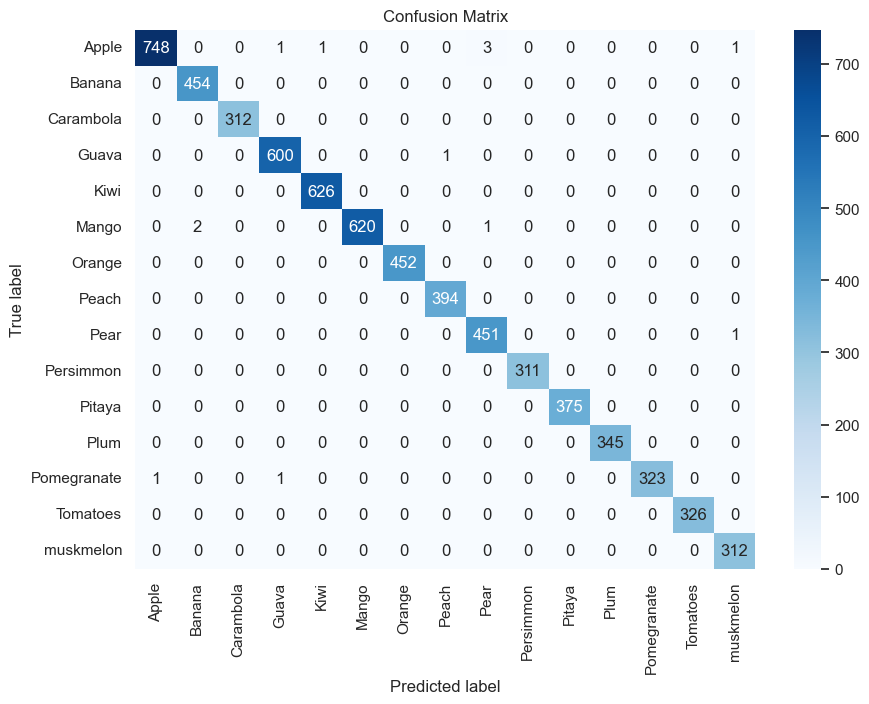

              precision    recall  f1-score   support

       Apple       1.00      0.99      1.00       754
      Banana       1.00      1.00      1.00       454
   Carambola       1.00      1.00      1.00       312
       Guava       1.00      1.00      1.00       601
        Kiwi       1.00      1.00      1.00       626
       Mango       1.00      1.00      1.00       623
      Orange       1.00      1.00      1.00       452
       Peach       1.00      1.00      1.00       394
        Pear       0.99      1.00      0.99       452
   Persimmon       1.00      1.00      1.00       311
      Pitaya       1.00      1.00      1.00       375
        Plum       1.00      1.00      1.00       345
 Pomegranate       1.00      0.99      1.00       325
    Tomatoes       1.00      1.00      1.00       326
   muskmelon       0.99      1.00      1.00       312

    accuracy                           1.00      6662
   macro avg       1.00      1.00      1.00      6662
weighted avg       1.00   

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model_with_metrics(model, dataloaders, device, class_names):
    model.eval()  # Colocar o modelo em modo de avaliação
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloaders['val'].dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

    # Calcular e plotar a matriz de confusão
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Relatório de classificação
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Chame a função de avaliação com métricas
class_names = dataloaders['train'].dataset.classes  # Obtém os nomes das classes
evaluate_model_with_metrics(model, dataloaders, device, class_names)


In [ ]:
def evaluate_model_with_f1(model, dataloaders, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'F1 Score: {f1:.4f}')


In [ ]:
def evaluate_model_with_precision_recall(model, dataloaders, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')


In [ ]:
# Avaliar o modelo no conjunto de validação com métricas
evaluate_model_with_f1(model, dataloaders, device)
evaluate_model_with_precision_recall(model, dataloaders, device)

F1 Score: 0.9980
Precision: 0.9981, Recall: 0.9980


### Realizando transformação e avaliação com nossos dados de Teste

In [ ]:
# Definindo o caminho para o diretório de teste
test_dir = "C:/Users/samue/OneDrive/Documentos/PROJETO_APLICADO/new_dataset_frutas/test"

# Defina as transformações a serem aplicadas às imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona as imagens
    transforms.ToTensor(),  # Converte para tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normaliza
])

# Criar o DataLoader para o conjunto de teste
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Não embaralhe os dados para teste


evaluate_model(model, test_loader, device)


Test Accuracy: 0.9979


### Em todas as metricas obtevemos resultados satisfatórios

Test Accuracy: 0.9979


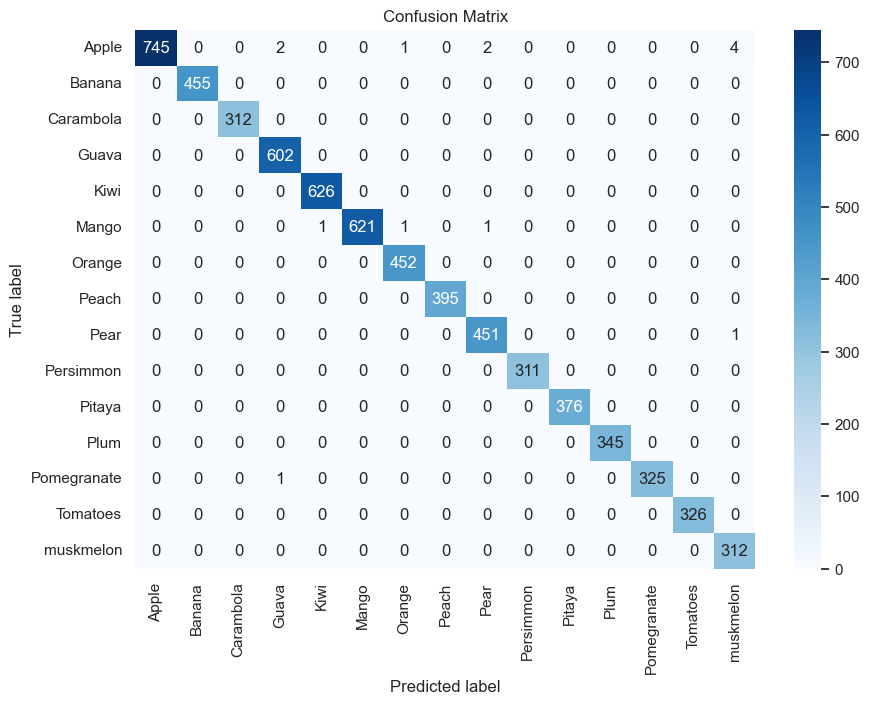

              precision    recall  f1-score   support

       Apple       1.00      0.99      0.99       754
      Banana       1.00      1.00      1.00       455
   Carambola       1.00      1.00      1.00       312
       Guava       1.00      1.00      1.00       602
        Kiwi       1.00      1.00      1.00       626
       Mango       1.00      1.00      1.00       624
      Orange       1.00      1.00      1.00       452
       Peach       1.00      1.00      1.00       395
        Pear       0.99      1.00      1.00       452
   Persimmon       1.00      1.00      1.00       311
      Pitaya       1.00      1.00      1.00       376
        Plum       1.00      1.00      1.00       345
 Pomegranate       1.00      1.00      1.00       326
    Tomatoes       1.00      1.00      1.00       326
   muskmelon       0.98      1.00      0.99       312

    accuracy                           1.00      6668
   macro avg       1.00      1.00      1.00      6668
weighted avg       1.00   

In [ ]:
# Criar o DataLoader para o conjunto de teste
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Não embaralhe os dados para teste

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model_with_metrics(model, dataloader, device, class_names):
    model.eval()  # Colocar o modelo em modo de avaliação
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Calcular e plotar a matriz de confusão
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Relatório de classificação
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Chame a função de avaliação com métricas no conjunto de teste
class_names = test_dataset.classes  # Obtém os nomes das classes do conjunto de teste
evaluate_model_with_metrics(model, test_loader, device, class_names)


In [ ]:
# Salvar o modelo
torch.save(model.state_dict(), 'modelo_treinado_pt2.pth')